# Housing Sale Prediction

<b> Author: </b> Shannon Snively

For this project the goal is to clean the dataset, find the important features, extract those features and create a model that will accurately reflect predicted housing prices compared to the actual. The link to the Kaggle competition is below:

<a></a>

Some of the different model techniques demonstrated:
* Ridge Regression
* Lasso Regerssion
* ElasticNet Regression
* Random Forest Regression
* AdaBoost

Different packages required:
* Pandas
* Sklearn

# Introduction

With all types of consumer industries there is always a need to understand what is the driving force behind value. For this particular supervised learning problem provided by Kaggle we are provided with two different datasets. The Train data consists of different housing attributes (i.e. roof type, number of rooms, type of house) and a response variable which is the housing sales price. The Test dataset contains the same variables minus the response attribute. 

The idea is to be able to extract important features from the datasets and create a model that will accruately predict the sales price. With limited knowledge of the data, the first step is to upload and explore.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# set index_col to the 'Id' Number
train = pd.read_csv(r'Data/train.csv', index_col = 0)
test = pd.read_csv(r'Data/test.csv', index_col = 0)

## Data Exploration

In [2]:
# train.head()
# train.describe()
# train.info()
# train.columns
train.shape

(1460, 80)

In [3]:
# test.head()
# test.describe()
# test.info()
# test.columns
test.shape

(1459, 79)

## Missing Data

In this section I combine the train and test data, analyze the missing data, and determine the appropriate imputing method. The idea of combing the two datasets together is that it will give stronger reflection of the population for imputing purposes, and will be easier to clean together. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from collections import Counter

### 1. Combine Data

In [5]:
# create train, test set, then combine together minus the response variable
X_train, y_train, X_test = train.iloc[:,:-1], train['SalePrice'], test.iloc[:,:]

stacked_df = pd.concat([X_train, X_test])
print(stacked_df.shape)

(2919, 79)


### 2. Analyze Data

In [6]:
print(stacked_df.isnull().sum()[stacked_df.isnull().sum() > 0])

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64


Above shows that there are several columns containing more than 1000 missing/NA values, which is roughly 30% of the data per column. To make sure that it was not an uneven balance of missing values between the two different data sets, I look at each individually. 

In [7]:
print(X_train.isnull().sum()[X_train.isnull().sum() > 1000])
print(X_test.isnull().sum()[X_test.isnull().sum() > 1000])

Alley          1369
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64
Alley          1352
PoolQC         1456
Fence          1169
MiscFeature    1408
dtype: int64


### 3. Impute Categorical Data

It was also brought to my attention that certain categorical variables have 'NA' for 'No (Attribute)'. However, with the similar balance of missing values per dataset, I decided to remove those columns.

In [8]:
cols_remove = list([i for i in range(0,len(stacked_df.columns)) if stacked_df[stacked_df.columns[i]].isnull().sum() > 1000])
print(stacked_df[cols_remove].columns)

stacked_df = stacked_df.drop(stacked_df[cols_remove], axis=1)

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


Because of the issue I uncovered earlier with categorical data, I decided it would then be best to convert all NA to a string instead of having a categorical attribute contain a missing value. Below is a print out of categorical features with attribute name and an example of the content. 

In [9]:
categorical = []

for i in stacked_df.columns:
    if (stacked_df[i].isnull().sum() > 0) & (np.dtype(stacked_df[i]) == object):
        categorical.append(i)

stacked_df[categorical] = stacked_df[categorical].fillna('NA')

print(stacked_df[categorical].head(), 1)

   MSZoning Utilities Exterior1st Exterior2nd MasVnrType BsmtQual BsmtCond  \
Id                                                                           
1        RL    AllPub     VinylSd     VinylSd    BrkFace       Gd       TA   
2        RL    AllPub     MetalSd     MetalSd       None       Gd       TA   
3        RL    AllPub     VinylSd     VinylSd    BrkFace       Gd       TA   
4        RL    AllPub     Wd Sdng     Wd Shng       None       TA       Gd   
5        RL    AllPub     VinylSd     VinylSd    BrkFace       Gd       TA   

   BsmtExposure BsmtFinType1 BsmtFinType2 Electrical KitchenQual Functional  \
Id                                                                            
1            No          GLQ          Unf      SBrkr          Gd        Typ   
2            Gd          ALQ          Unf      SBrkr          TA        Typ   
3            Mn          GLQ          Unf      SBrkr          Gd        Typ   
4            No          ALQ          Unf      SBrkr      

### 4. Impute Numerical Data

After taking care of the categorical data I was curious of how to deal with the remaining numerical values. I obtained the total sum of missing values for each variable, graphed the variables with large missing values to see skewness, and then also looked at the variables within the seperate train_df/ test_df to see if there was skewed results there as well. 

Based upon looking at the normal distribution of the data, it would suggest whether to impute the mean or median of the dataset.

In [10]:
print(stacked_df.isnull().sum()[stacked_df.isnull().sum() > 0])

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64


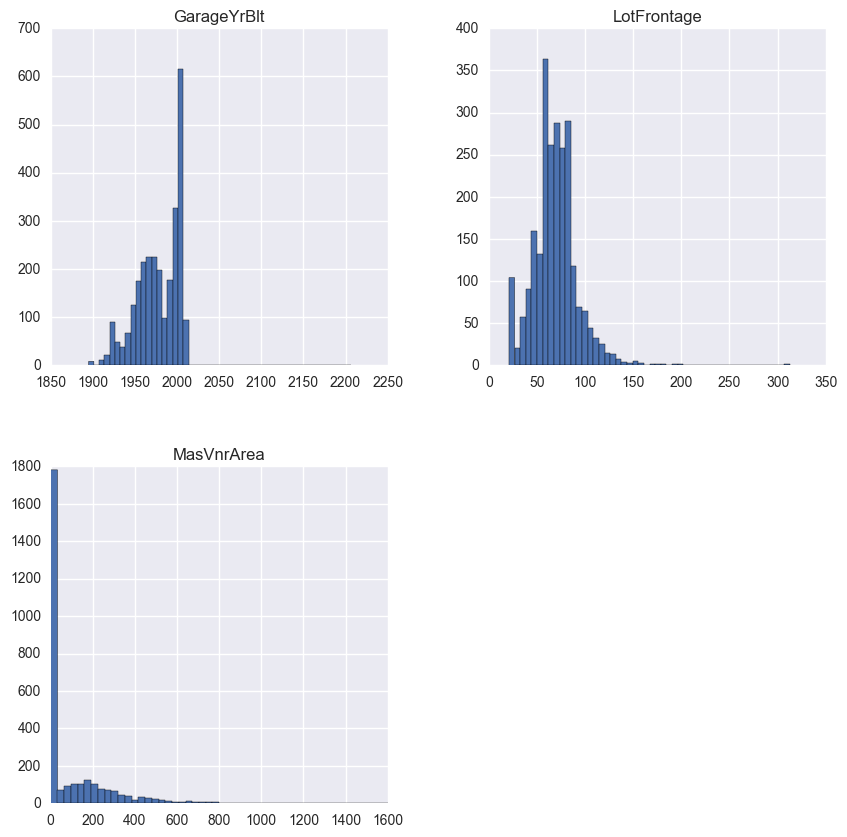

In [11]:
%matplotlib inline
stacked_df[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(bins=50, figsize=(10,10));

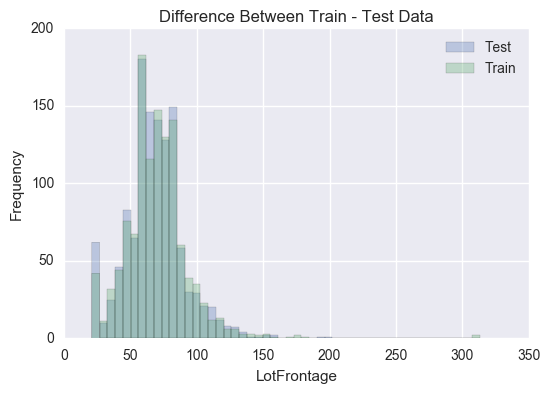

In [12]:
%matplotlib inline
train_test_lot = pd.DataFrame({'Test': X_test['LotFrontage'], 'Train': X_train['LotFrontage']}, columns = ['Test', 'Train'])

plt.figure(figsize=(10, 10))

train_test_lot.plot.hist(alpha= 0.3, bins=50)

plt.title('Difference Between Train - Test Data')
plt.xlabel('LotFrontage');

In the end the skewed results between the different variables, determined that imputing the median would be the best idea.

In [13]:
numerical = []

for i in stacked_df.columns:
    if (stacked_df[i].isnull().sum() > 0) & (np.dtype(stacked_df[i]) != object):
        numerical.append(i)
        
# print(stacked_df[numerical].head())

imr = Imputer(missing_values='NaN', strategy='median')
imr = imr.fit(stacked_df[numerical])
stacked_df[numerical] = imr.transform(stacked_df[numerical])

print(stacked_df.isnull().sum()[stacked_df.isnull().sum() > 0])

Series([], dtype: int64)


Lastly, there were a few other attributes that based upon subject matter knowledge were skewed in a direction that provided little value to the model. For example the attribute removed were:

<b>Street</b>  : Counter({'Pave': 2907, 'Grvl': 12}) 

<b>Utilities</b>  : Counter({'AllPub': 2916, 'NA': 2, 'NoSeWa': 1})

<b>Heating</b>  : Counter({'GasA': 2874, 'GasW': 27, 'Grav': 9, 'Wall': 6, 'OthW': 2, 'Floor': 1})

<b>Condition2</b>  : Counter({'Norm': 2889, 'Feedr': 13, 'Artery': 5, 'PosA': 4, 'PosN': 4, 'RRNn': 2, 'RRAe': 1, 'RRAn': 1})

In [14]:
stacked_df = stacked_df.drop(['Street', 'Condition2', 'Utilities', 'Heating'], axis=1)

## Convert categorical into dummy variables

Based on the given data dictionary the following categorical variables were determined to be either binary, oridinal, or nominal which is needed to convert them into dummy variables. 

* The only binary variable was 'CentralAir'.

* The variables that I found to be ordinal, are ranked from 0 - len(stacked_df['LotShape']). With 0 starting as a considered worse option and incrementally gets better.

* The remaining objects were considered as nominal.

After converting the data, a new dataframe was created with the numerical data and new dummy variable data.

In [15]:
# one binary: merged_df['CentralAir']
stacked_df['CentralAir'] = stacked_df['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

In [16]:
# ordinal data:
LotShape_map = {
    'Reg':3,
    'IR1':2,
    'IR2':1,
    'IR3':0
}
stacked_df['LotShape'] = stacked_df['LotShape'].map(LotShape_map)

LandSlope_map = {
    'Gtl':2, 
    'Mod':1, 
    'Sev':0
}
stacked_df['LandSlope'] = stacked_df['LandSlope'].map(LandSlope_map)

HouseStyle_map = {
    '1Story':0, 
    '1.5Unf':1, 
    '1.5Fin':2, 
    '2Story':3, 
    '2.5Unf':4, 
    '2.5Fin':5,
    'SFoyer':6, 
    'SLvl':7
}
stacked_df['HouseStyle'] = stacked_df['HouseStyle'].map(HouseStyle_map)

BsmtExposure_map = {
    'NA':0, 
    'No':1, 
    'Mn':2, 
    'Av':3, 
    'Gd':4
}
stacked_df['BsmtExposure'] = stacked_df['BsmtExposure'].map(BsmtExposure_map) 

Electrical_map = {
    'Mix':0,
    'FuseP':1,
    'FuseF':2,
    'FuseA':3,
    'SBrkr':4,
    'NA': 4
}
stacked_df['Electrical'] = stacked_df['Electrical'].map(Electrical_map)

Functional_map = {
    'Sal':0,
    'NA':0,
    'Sev':1,
    'Maj2':2,
    'Maj1':3,
    'Mod':4,
    'Min2':5,
    'Min1':6,
    'Typ':7
}
stacked_df['Functional'] = stacked_df['Functional'].map(Functional_map)

GarageFinish_map = {
    'NA':0,
    'Unf':1,
    'RFn':2,
    'Fin':3
}
stacked_df['GarageFinish'] = stacked_df['GarageFinish'].map(GarageFinish_map)

Overall_map = {
    '1':0, 
    '2':1, 
    '3':2, 
    '4':3, 
    '5':4, 
    '6':5, 
    '7':6, 
    '8':7, 
    '9':8, 
    '10':9
}
Overall_list = ['OverallQual', 'OverallCond']
for col in Overall_list:
    stacked_df[col] = stacked_df[col].map(Overall_map).astype(str)

Quality_map = {
        'NA': 0, 
        'Po': 1, 
        'Fa':2, 
        'TA':3, 
        'Gd':4, 
        'Ex':5
}
Quality_list = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
for col in Quality_list:
    stacked_df[col] = stacked_df[col].map(Quality_map) 

BsmtFinType_map = {
            'NA':0, 
            'Unf':1, 
            'LwQ':2, 
            'Rec':3, 
            'BLQ':4, 
            'ALQ':5, 
            'GLQ':6
}
BsmtFinType_list = ['BsmtFinType1', 'BsmtFinType2']
for col in BsmtFinType_list:
    stacked_df[col] = stacked_df[col].map(BsmtFinType_map)                                                                         

In [17]:
stacked_df['MSSubClass'] = stacked_df['MSSubClass'].astype(str)
# print(np.dtype(stacked_df['MSSubClass']))

In [18]:
# nominal data:
dummy_df = pd.DataFrame()

for col in stacked_df.columns:
    if np.dtype(stacked_df[col]) == object:
        dummy_df = pd.concat([dummy_df, pd.get_dummies(stacked_df[col])], axis=1)
        stacked_df = stacked_df.drop(col, axis = 1)

# dummy variable is concatinated with stacked_df, and then the original variable is dropped from stacked_df 
print(dummy_df.shape)

(2919, 156)


In [19]:
# combines the binary, ordinal, nominal, and numerical variables in one
merged_df = pd.merge(stacked_df, dummy_df, right_index= True, left_index=True)
print(merged_df.shape)

(2919, 207)


# Seperate  back to train / test

The Train/ Test data is split back to original based on shape of the Train sets original row size, in order to avoid using the test set during regression analysis. 

In [20]:
from sklearn.cross_validation import train_test_split

C:\Users\Shannon\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
X_train, X_test = merged_df.iloc[:train.shape[0]], merged_df.iloc[train.shape[0]:]
print('X_train:', X_train.shape, 'X_test:', X_test.shape)

X_train: (1460, 207) X_test: (1459, 207)


In [22]:
split_train_X, split_test_X, split_train_y, split_test_y = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
print(split_train_X.shape, split_test_X.shape, split_train_y.shape, split_test_y.shape)

(1314, 207) (146, 207) (1314,) (146,)


# Linear Regression

In the next section I will cover a series of different models and describe best practices for each. There will also be a comparison of two different scoring methods to demonstrate, which one might be more relevant to use. 

Scoring methods:
* RMSE
* RMSLE

In [23]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [24]:
def rmse_scoring(y_actual, y_pred):
     return -np.sqrt(((y_actual - y_pred) ** 2).mean())
#     return(sqrt(mean_squared_error(y_actual, y_predicted)))
rmse = make_scorer(rmse_scoring)

### Ridge

Ridge is a shrinkage method similar to ordinary least square but gives an additional penalty that penalizes the size of regression coefficients towards 0. λ is know as the tuning parameter, which in this case controls the strength of penalty when λ ≥ 0. When λ = 0 it is the linear regression estimate, and when λ = ∞, the coefficients are βˆridge = 0. Therefore if λ is inbetween (0, ∞) the coefficients will shrink towards the value of 0.

<b> Scoring Method: </b> The scoring method used is MSE, is used to gain the results with of the estimator that gains the overall least error between the predicted and the actual.

<b> Parameters: </b> The gridsearch runs a cross validation by each parameter combination in order to get the best parameter for the model. 

In [25]:
def regression_model(estimator, params):
    
    grid_cv = GridSearchCV(estimator(random_state=1), params, cv=10, scoring= rmse)
    grid_cv.fit(split_train_X, split_train_y)
    grid_predict = grid_cv.predict(split_test_X)
    price_difference = sum(abs(split_test_y - grid_predict))/len(grid_predict)
    
    print('Best Parameters for ', estimator, ':', grid_cv.best_params_)
    print('Best Score for ', estimator, ':', grid_cv.best_score_)
    print('Price Difference for ', estimator, 'is: ', price_difference)
    
    return grid_cv, grid_predict

def plot_regression(grid_predict):
    
    plt.title('Difference in Predicted SalesPrice')
    plt.ylabel('SalesPrice')
    return plt.plot(range(len(grid_predict)), split_test_y - grid_predict)

In [26]:
ridge_params = {
    'alpha' : np.arange(.01, 1, .01)
}

ridge, ridge_pred = regression_model(Ridge, ridge_params)

Best Parameters for  <class 'sklearn.linear_model.ridge.Ridge'> : {'alpha': 0.67000000000000004}
Best Score for  <class 'sklearn.linear_model.ridge.Ridge'> : -34504.2083232
Price Difference for  <class 'sklearn.linear_model.ridge.Ridge'> is:  19456.3191901


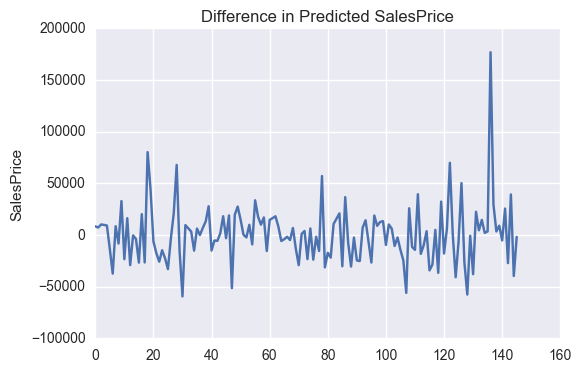

In [27]:
%matplotlib inline

plot_regression(ridge_pred);

Given the best parameters, the model then runs the prediction of the X values. Due to the mix of multiclass and continuous variables, the best visual to see accuracy is the average of how far off the predicted salesprice is from the actual. Below shows that on average with Ridge Regression the model predicts higher/lower of $20k. 

The graph belows shows each ID in the test_set and the difference from actual (y-axis: 0) to the predicted.

In [28]:
row_id = split_test_y[abs(split_test_y - ridge_pred) >= 100000].index[0]

X_train = X_train.drop(row_id, axis=0)
y_train = y_train.drop(row_id, axis=0)

split_train_X, split_test_X, split_train_y, split_test_y = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

print(split_train_X.shape, split_test_X.shape, split_train_y.shape, split_test_y.shape)

(1313, 207) (146, 207) (1313,) (146,)


In [29]:
ridge2, ridge_pred2 = regression_model(Ridge, ridge_params)

Best Parameters for  <class 'sklearn.linear_model.ridge.Ridge'> : {'alpha': 0.31}
Best Score for  <class 'sklearn.linear_model.ridge.Ridge'> : -34846.4578217
Price Difference for  <class 'sklearn.linear_model.ridge.Ridge'> is:  16746.8677077


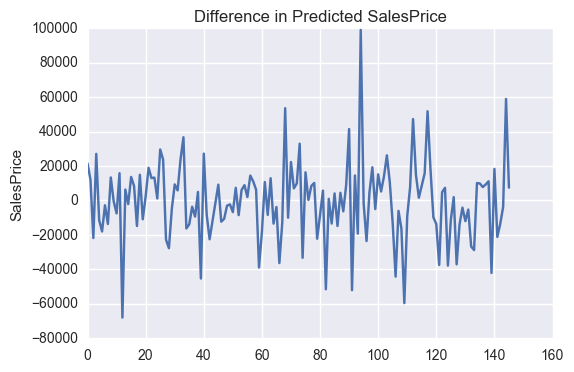

In [30]:
plot_regression(ridge_pred2);

### Lasso Regression

In [31]:
# To save on time narrowed parameter range, after finding optiminal parameter
lasso_params = {
    'alpha' : np.arange(20, 30, 0.25)
}

lasso, lasso_pred = regression_model(Lasso, lasso_params)

Best Parameters for  <class 'sklearn.linear_model.coordinate_descent.Lasso'> : {'alpha': 29.75}
Best Score for  <class 'sklearn.linear_model.coordinate_descent.Lasso'> : -33672.6267574
Price Difference for  <class 'sklearn.linear_model.coordinate_descent.Lasso'> is:  16115.2160796


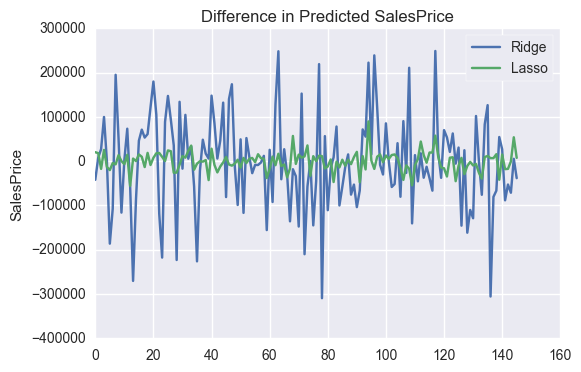

In [32]:
ax1 = plot_regression(ridge_pred)
ax2 = plot_regression(lasso_pred)
plt.legend((ax1[0], ax2[0]), ('Ridge', 'Lasso'), frameon=True)
plt.show()

Because Lasso also elimates coefficients by setting them equal to 0, below shows columns that are greater than zero. The code commented out shows the index of the column and the value of the best estimated coefficient.

In [33]:
coef = lasso.best_estimator_.coef_
not_zero_indices = np.where(coef!=0)
print(X_train.columns[not_zero_indices])

Index(['LotFrontage', 'LotArea', 'LandSlope', 'HouseStyle', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond',
       ...
       'Detchd', 'NA', 'P', 'COD', 'Con', 'New', 'WD', 'Abnorml', 'Family',
       'Normal'],
      dtype='object', length=132)


## Important/ Contributing variables

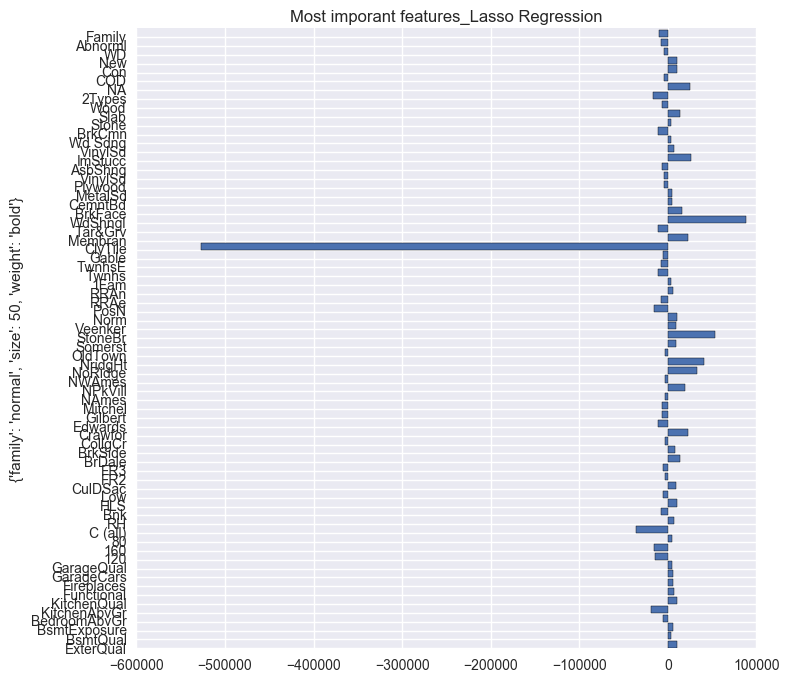

In [34]:
# can pick an arbitrary number >= because if look at lasso and coef some > 0 are very low, less impact

lg_coef = np.where(abs(coef) >= 3000)
fig = plt.figure(figsize=(8,8))

plt.barh(range(len(lg_coef[0])), coef[lg_coef[0]])
plt.yticks(range(len(lg_coef[0])), split_train_X.columns[lg_coef[0]])
plt.title('Most imporant features_Lasso Regression')

font = {
    'family':'normal',
    'weight':'bold',
    'size':50
}

plt.rc('font', **font);
plt.ylabel(font);

# matplotlib.rcParams.update({'font.size': 50})


In [35]:
# Find most important variables in the data + rank in order of importance, can't include the lasso gridsearch... 
lasso_rfe = Lasso(30, normalize= True, random_state=1)
selector = RFE(lasso_rfe, n_features_to_select= 10, step=1)
selector = selector.fit(split_train_X, split_train_y)
selector.support_ 
selector.ranking_

select = [(i, x) for i,x in enumerate(selector.ranking_) if x <= 65]
print(select)

[(0, 44), (1, 57), (4, 65), (5, 29), (6, 28), (7, 53), (8, 1), (10, 10), (12, 15), (14, 48), (18, 51), (19, 23), (21, 58), (22, 56), (23, 59), (24, 42), (25, 37), (28, 40), (30, 13), (31, 32), (32, 5), (33, 46), (34, 25), (35, 7), (36, 49), (38, 2), (39, 41), (42, 54), (43, 55), (46, 43), (47, 39), (49, 27), (51, 3), (53, 4), (56, 30), (67, 1), (73, 35), (74, 18), (78, 12), (85, 31), (88, 1), (89, 22), (97, 1), (98, 1), (99, 19), (103, 14), (104, 1), (105, 63), (108, 60), (109, 24), (111, 33), (114, 61), (116, 16), (119, 26), (120, 64), (124, 45), (126, 11), (129, 1), (131, 34), (136, 1), (140, 9), (143, 47), (153, 36), (160, 6), (170, 52), (174, 20), (178, 50), (181, 1), (187, 38), (193, 1), (198, 8), (200, 62), (201, 21), (204, 17)]


In [36]:
# Interesting to compare coef results from grid search to the ones labeled as most important in the RFE
coef_rfe = selector.estimator_.coef_
# grid_lasso_rm.best_estimator_.coef_
print(coef_rfe)

[  71270.35238218  -33486.50597501   42391.23662763  102551.436869
   71111.18471741   77396.46719455  -85791.98516413  153564.9892534
      -0.           63506.83977967]


## Random Forest Regression

Warning: The output will take a while to run if forked and ran on own computer.

Now if we remove the coef from Lasso regression equivalent to zero what do we get?

In [37]:
tree_params = {
    'n_estimators' : np.arange(80, 130, 10),
    'max_depth': np.arange(8, 10, 1)
}

def tree_model(estimator, params):
    grid_cv = GridSearchCV(estimator(random_state=1), params, cv=10, scoring= rmse)
    grid_cv.fit(split_train_X, split_train_y)
    grid_predict = grid_cv.predict(split_test_X)
    price_difference = sum(abs(split_test_y - grid_predict))/len(grid_predict)
    
    print('Best Parameters for ', estimator, ':', grid_cv.best_params_)
    print('Best Score for ', estimator, ':', grid_cv.best_score_)
    
    return grid_cv, grid_predict

In [38]:
randomforest, randomforest_pred = regression_model(RandomForestRegressor, tree_params)

Best Parameters for  <class 'sklearn.ensemble.forest.RandomForestRegressor'> : {'n_estimators': 100, 'max_depth': 9}
Best Score for  <class 'sklearn.ensemble.forest.RandomForestRegressor'> : -30565.9148508
Price Difference for  <class 'sklearn.ensemble.forest.RandomForestRegressor'> is:  17546.1948736


In [39]:
# curious to see how removing the columns that were equalized to zero in lasso will affect the random forest regression

rm_cols = X_train.columns[not_zero_indices]
split_train_X2, split_test_X2 = split_train_X.drop(rm_cols, axis=1), split_test_X.drop(rm_cols, axis=1)

print(split_train_X2.shape, split_test_X2.shape)

(1313, 62) (146, 62)


In [40]:
#randomforest_new = regression_model(RandomForestRegressor, tree_params)

randomforest.fit(split_train_X2, split_train_y)
random_predict2 = randomforest.predict(split_test_X2)
print(sum(abs(split_test_y - random_predict2))/len(random_predict2))
print('Best Parameters: ', randomforest.best_params_)
print('Best Score: ', randomforest.best_score_)

44873.1839714
Best Parameters:  {'n_estimators': 80, 'max_depth': 9}
Best Score:  -61281.3636422


# Implement Test

In [41]:
grid_cv = GridSearchCV(Lasso(random_state=1), lasso_params, cv=10, scoring= rmse)
grid_cv.fit(X_train, y_train)
grid_predict = grid_cv.predict(X_test)

In [42]:
results = pd.DataFrame({"Id":X_test.index, "SalePrice":grid_predict})

In [ ]:
results.to_csv('test_results.csv', index=False)